In [14]:
import numpy as np
import utils
from data import loader
import math
from model.rvae import RVAE
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt
import umap
from scipy import stats

% matplotlib widget

In [2]:
config = utils.read_cfg('../config/template.yaml')
train, test_scenarios = loader.load(config)
test = test_scenarios['ctu-1-2-9']

train_norm, train_bot = utils.split_mal_norm(train)
count_x = math.floor(train_norm.shape[0] / 5)
train_norm = utils.remove_ylabel(train_norm)
train_norm = utils.reshape_for_rnn(train_norm.values)

train_bot = utils.remove_ylabel(train_bot)
train_bot = utils.reshape_for_rnn(train_bot.values)

test_norm, test_bot = utils.split_mal_norm(test)
test_norm = utils.remove_ylabel(test_norm)
test_norm = utils.reshape_for_rnn(test_norm.values)
test_bot = utils.remove_ylabel(test_bot)
test_bot = utils.reshape_for_rnn(test_bot.values)

feature_dim = train_norm.shape

In [6]:
red = umap.UMAP()
emb = red.fit_transform(train_norm.reshape(train_norm.shape[0], 5 * 23))

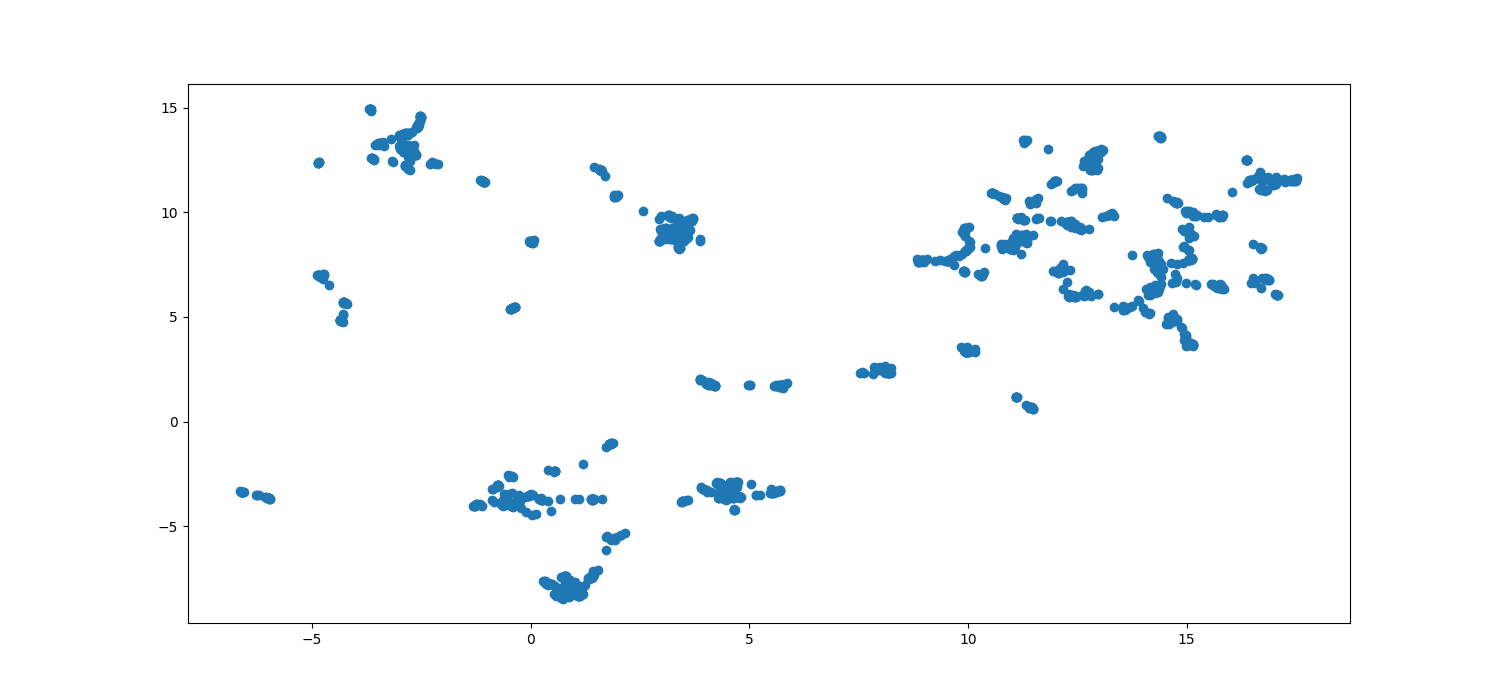

In [7]:
plt.figure(figsize=(15, 7))
plt.scatter(emb[:, 0], emb[:, 1])
plt.show()

In [36]:
encoder_inputs = keras.Input(shape=(feature_dim[1], feature_dim[2]))
encoder_layers = layers.GRU(units=10)(encoder_inputs)
encoder_layers = layers.LeakyReLU(alpha=0.01)(encoder_layers)

# latent dim 3 for visualisation
latent_inputs = keras.Input(shape=(2))
decoder_layers = layers.Dense(feature_dim[2] * feature_dim[1])(latent_inputs)
decoder_layers = layers.Reshape((feature_dim[1], feature_dim[2]))(decoder_layers)
decoder_layers = layers.GRU(units=10, activation='relu', return_sequences=True)(decoder_layers)
decoder_layers = layers.Dense(5)(decoder_layers)

vae = RVAE(encoder_inputs, encoder_layers, latent_inputs, decoder_layers)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(train_norm, epochs=500, batch_size=128)

Epoch 1/500
14/14 [==============================] - 3s 13ms/step - loss: 12.6041 - reconstruction_loss: 11.7706 - kl_loss: 0.0059 - z_mean: -0.0410 - z_log_var: -0.0790
Epoch 2/500
14/14 [==============================] - 0s 12ms/step - loss: 10.0465 - reconstruction_loss: 9.7353 - kl_loss: 0.0057 - z_mean: -0.0303 - z_log_var: -0.0812
Epoch 3/500
14/14 [==============================] - 0s 12ms/step - loss: 8.5511 - reconstruction_loss: 8.1180 - kl_loss: 0.0076 - z_mean: -0.0226 - z_log_var: -0.0859
Epoch 4/500
14/14 [==============================] - 0s 11ms/step - loss: 7.0923 - reconstruction_loss: 6.8769 - kl_loss: 0.0101 - z_mean: -0.0178 - z_log_var: -0.0929
Epoch 5/500
14/14 [==============================] - 0s 11ms/step - loss: 6.4440 - reconstruction_loss: 6.3044 - kl_loss: 0.0130 - z_mean: -0.0142 - z_log_var: -0.1006
Epoch 6/500
14/14 [==============================] - 0s 11ms/step - loss: 5.9704 - reconstruction_loss: 5.9362 - kl_loss: 0.0162 - z_mean: -0.0113 - z_log_va

In [37]:
mu, log_sig, z = vae.encoder.predict(train_norm)
nu_mal, log_sig_mal, z_mal = vae.encoder.predict(train_bot)

In [38]:
mean_norm = np.mean(z, axis=0)
std_norm = np.std(z, axis=0)
z_scores = stats.zscore(z, axis=0)
mean_z_scores = np.mean(z_scores, axis=1)
np.max(z_scores, axis=0)

array([3.6948981, 4.2803216], dtype=float32)

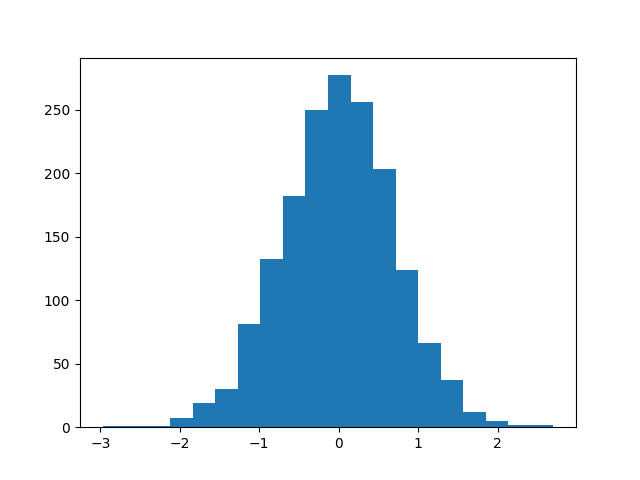

In [40]:
plt.figure()
plt.hist(mean_z_scores, bins=20)
plt.show()

In [43]:
bad_reps_idx = np.array(np.where(1 < np.abs(mean_z_scores)))

bad_reps = train_norm[bad_reps_idx]

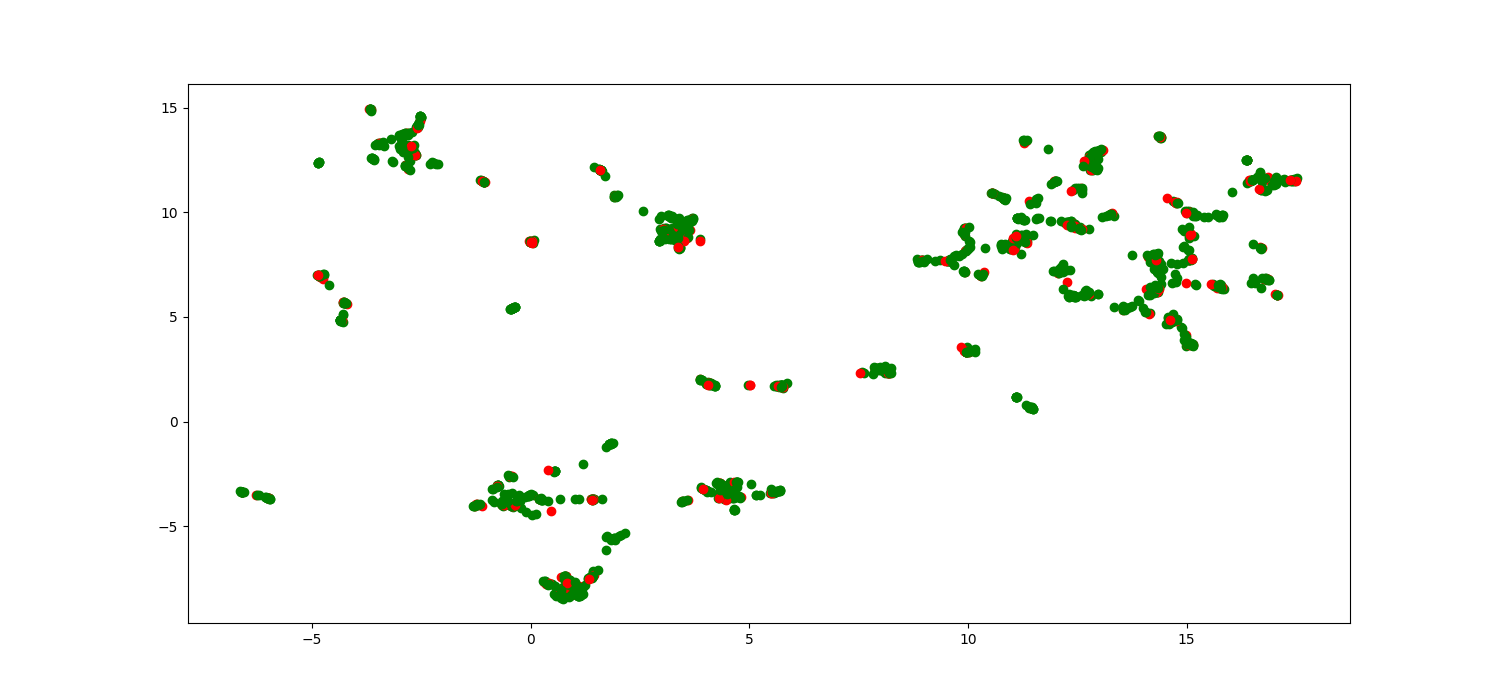

In [44]:
plt.figure(figsize=(15, 7))
# plt.scatter(emb[:, 0], emb[:, 1])
# plt.show()

for i in range(0, emb.shape[0]):
    col = 'red' if i in bad_reps_idx else 'green'
    plt.scatter(emb[i][0], emb[i][1], color=col)
plt.show()

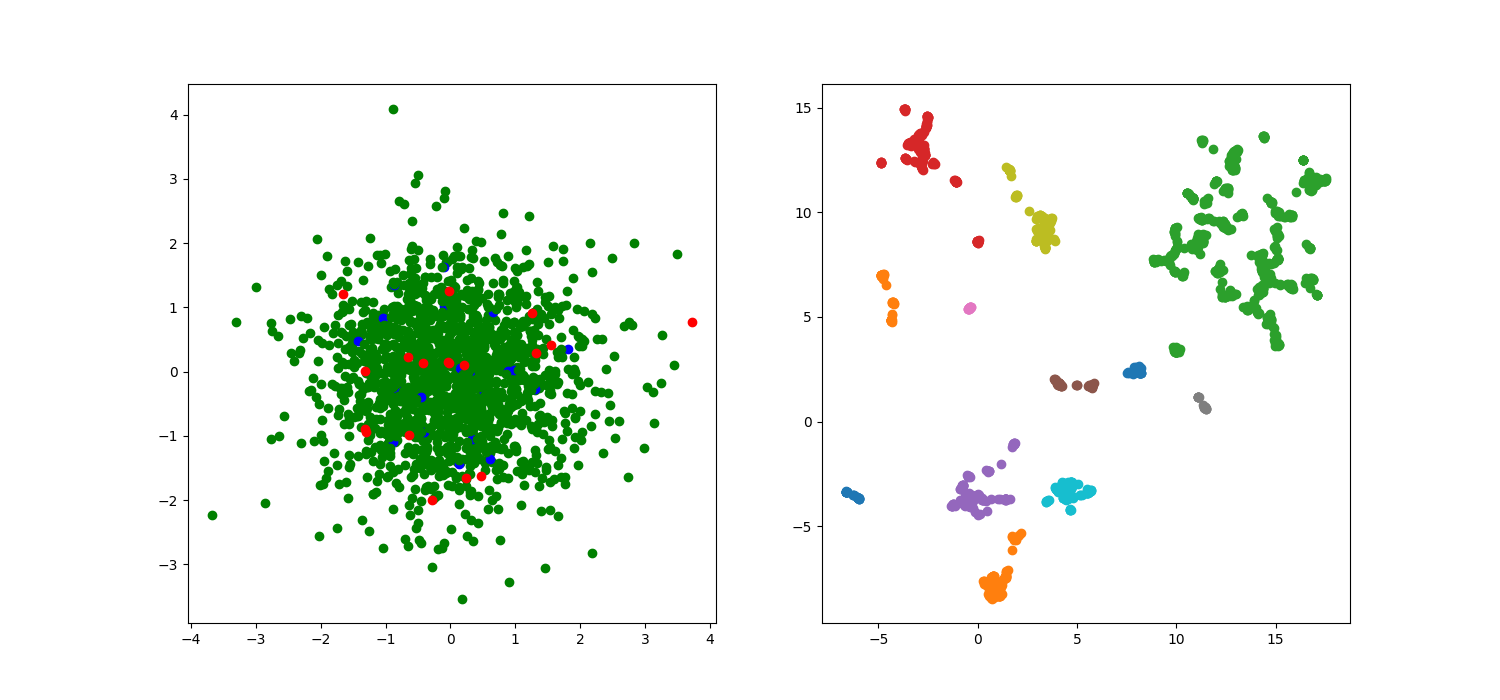

In [65]:
model = DBSCAN(eps=1.5, min_samples=2)
yhat = model.fit_predict(emb)
clusters = np.unique(yhat)
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
cluster_stats = []
for cluster in clusters:
    row_ix = np.where(yhat == cluster)
    cluster_data = z[row_ix]
    cluster_stats.append([np.mean(cluster_data, axis=None), np.std(cluster_data, axis=None)])

cluster_statss = np.array(cluster_stats)

max_var = np.argmax(cluster_statss[:, 1])
min_var = np.argmin(cluster_statss[:, 1])
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    cluster_data = z[row_ix]
    # if cluster_data.shape[0]:
    col = 'green'
    if cluster == max_var:
        col = 'red'
    if cluster == min_var:
        col = 'blue'
    ax[0].scatter(z[row_ix, 0], z[row_ix, 1], color=[col for val in z[row_ix, 0]])
    ax[1].scatter(emb[row_ix, 0], emb[row_ix, 1])
    # else:
    # plt.scatter(z[row_ix, 0], z[row_ix, 1], alpha=0.3)
# create scatter of these samples
plt.show()